# Acquisition of the raw ultrasound image 

Taking advantage of a Vref/2 offset at the ADC level

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.signal.signaltools as sigtool
from scipy.interpolate import griddata
import math

In [2]:
npzfile = np.load("GainB.npz")
print(npzfile.files)
Image = npzfile["RawData"]
RawData = np.asarray(Image,dtype = np.int32)

#Changing lines with strange behaviors
Vars = np.var(RawData,1)/1000
for i in range(len(Vars)):
    if (Vars[i]>1):
        RawData[i] = RawData[i-1]

['RawData']


## Let's see what one line looks like.

We should see an echo, offset by Vref / 2, for a 9 bit ADC, that's an offset of 256 (or 1.65V )

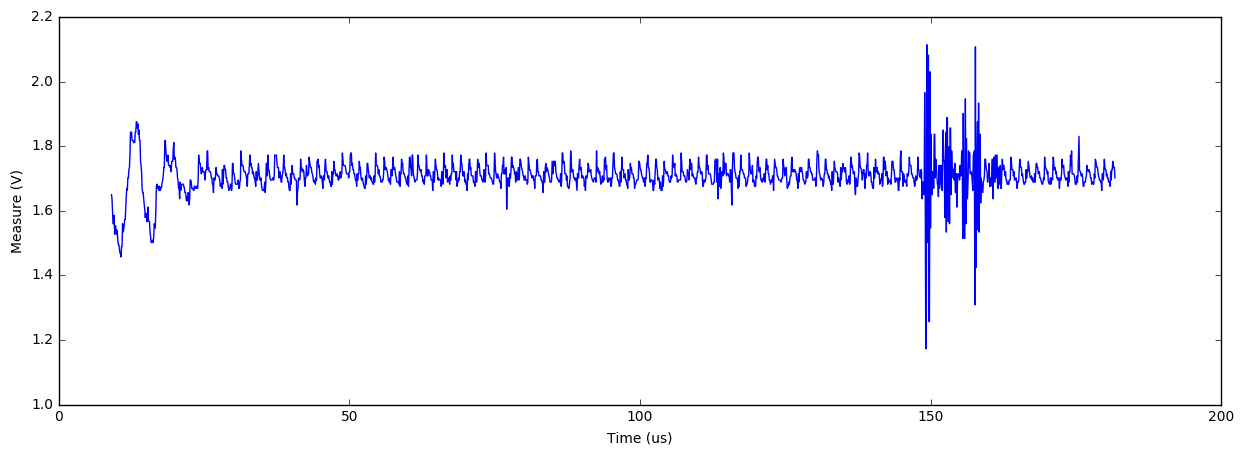

In [138]:
tmpline = RawData[70]
plt.figure(figsize=(15,5))
t = [x / 11.0 for x in range(len(tmpline))]
plt.plot(t[100:2000],tmpline[100:2000]*3.3/512.0)
plt.xlabel("Time (us)")
plt.ylabel("Measure (V)")
plt.show()

In [139]:
def ProcessLine(Line):
    LenLines = len(Line)
    FFTMap = []
    Min = np.average(Line[8000:9000])
    for k in range(LenLines-1):
        if (Line[k+1] > 400):
            Line[k+1] =(RawData[l][k] + RawData[l][k+2])/2

    FFTed = np.fft.fft(Line)

    for i in range(3000):
        FFTed[i] = 0
        FFTed[-i] = 0
    for i in range(1000): 
        FFTed[4000+i] = 0
        FFTed[-i-4000] = 0

    SigFil = np.real(np.fft.ifft(FFTed))[0:2400]
    
    return Line-Min,SigFil

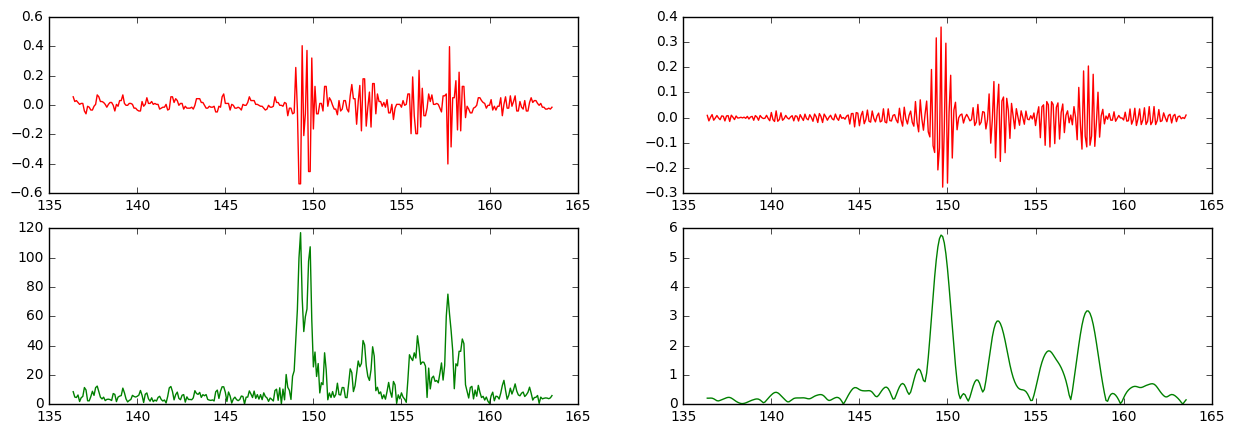

In [140]:
Line,Filtered = ProcessLine(Image[70])
SigHF = np.abs(signal.hilbert(Filtered))
SigH = np.abs(signal.hilbert(Line))
t = [x / 11.0 for x in range(len(Line))]
fig, ax = plt.subplots( nrows=2, ncols=2,figsize=(15,5))
ax[0,0].plot(t[1500:1800],Line[1500:1800]*3.3/512,"r")  # plotting 50x 100ns, that's 5µs
ax[1,0].plot(t[1500:1800],(SigH)[1500:1800],"g" )  # plotting 50x 100ns, that's 5µs
ax[0,1].plot(t[1500:1800],Filtered[1500:1800]*3.3/512,"r")  # plotting 50x 100ns, that's 5µs
ax[1,1].plot(t[1500:1800],(SigHF)[1500:1800]/10,"g" )  # plotting 50x 100ns, that's 5µs

plt.show()

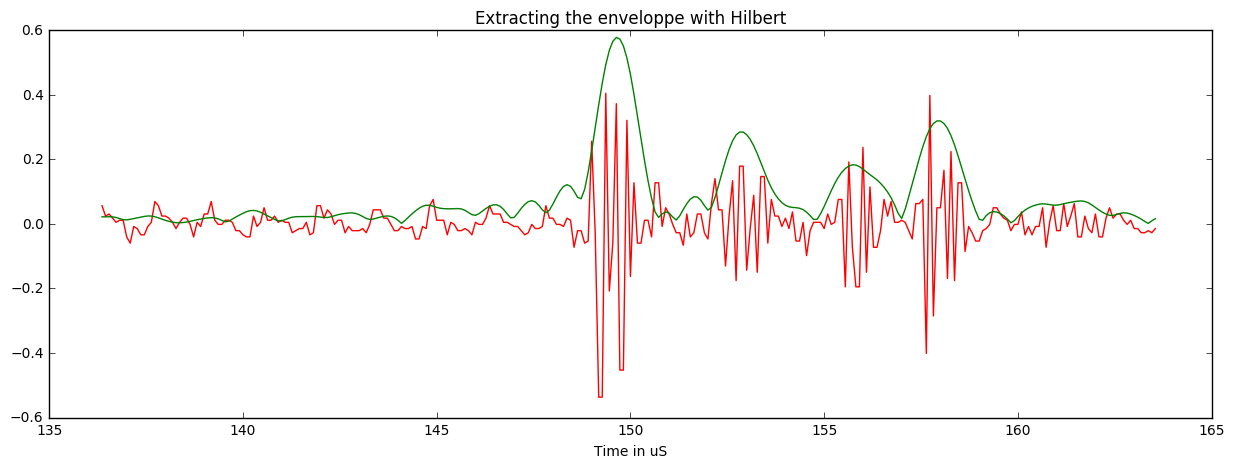

In [141]:
plt.figure(figsize=(15,5))
plt.plot(t[1500:1800],Line[1500:1800]*3.3/512,"r")
plt.plot(t[1500:1800],(SigHF)[1500:1800]/100,"g")
plt.xlabel("Time in uS")
plt.title("Extracting the enveloppe with Hilbert")
plt.show()

In [96]:
NbLines, LenLines = np.shape(RawData)

OffSets = []
FFTMap = []
Small = []
Cleaned = []
Hilberted = []
tmp = RawData[0][100:200]

for l in range(NbLines):
    Line,Filtered = ProcessLine(RawData[l])
    BegLine = Line[100:250]
    Corr = signal.correlate((tmp-260)/40, (BegLine-260)/40, mode='same') 
    ACorr = np.argmax(Corr) #
    OffSets.append((ACorr))
    Small.append(RawData[l][0:2200])
    Cleaned.append(np.abs(Filtered))
    Hilberted.append(np.abs(signal.hilbert(Filtered)))
    tmp = np.fft.fft(Line)

    FFTMap.append(tmp)
OffMax = max(OffSets) 


### Mapping the frequency domain

There seems to be a sort of folding, plus some strips remaining 

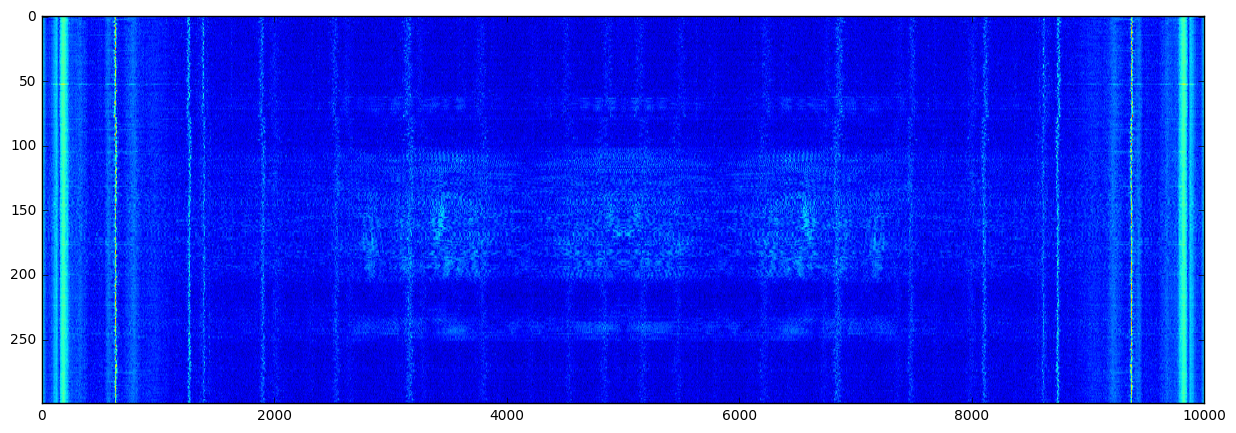

In [97]:
plt.figure(figsize=(15,5))
plt.imshow(np.sqrt(np.abs(FFTMap)),aspect="auto")
plt.show()

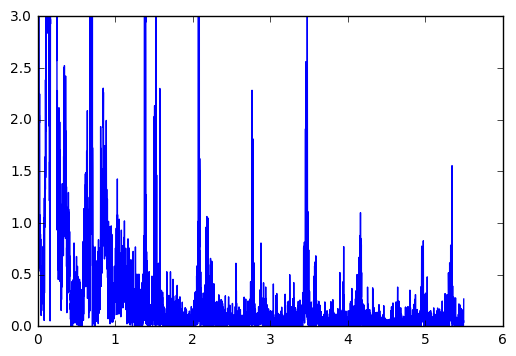

In [116]:
FFT = (np.abs(FFTMap)[0]**2)/0.6e6
f= [1.0*x/len(MainFreq)*11  for x in range(len(MainFreq))]
MainFreq = np.array(FFT, dtype=np.int)
plt.plot(f[0:len(MainFreq)/2],FFT[0:len(MainFreq)/2])
plt.ylim([0,3])
plt.show()

## Size

* Without decimation, we have on line the right gabarit. We find that resolution is 14.93 px / mm. That's around 15px / mm. 

* The speed of sound is 1500m/s, so on the image we have 1.332us/mm.
* Acquisition speed is therefore 14.93/1.332 is 11.2Msps.
* The acquarium wall is at 100mm, that should be 1493px

In [26]:
Decimation = 5 
DecSL = 3
NotCentered = 224
NbLinesC = NbLines/Decimation
LenLinesC = LenLines+OffMax+NotCentered+1

    
def CreateImage(Hilberted):
    NbLines, LenLines = np.shape(Cleaned)
    Image = np.abs(Cleaned)


    Corrected = np.zeros((NbLines, LenLines+OffMax+NotCentered))
    RawImage = np.zeros((NbLines/Decimation, LenLines+OffMax+NotCentered))
    SmallTwo = np.zeros(np.shape(Small))



    for i in range(NbLines):
        for j in range(LenLines-OffMax):
            Corrected[i][j+NotCentered] = Hilberted[i][j-OffSets[i]+OffMax]
            if (j<1500):
                SmallTwo[i][j+NotCentered] = Small[i][j-OffSets[i]+OffMax]
    Corrected[97] = Corrected[96]
    Corrected = Corrected-np.amin(Corrected)
    Corrected = np.sqrt(Corrected)


    for j in range(NbLines/Decimation):
        for k in range(Decimation):
            RawImage [j] += Corrected[Decimation*j+k]

    RawImg = np.zeros((NbLines/Decimation, (LenLines-OffMax)/DecSL))

    for i in range(NbLines/Decimation):
        for j in range((LenLines-OffMax)/DecSL):
            for k in range(DecSL):
                RawImg [i][j] += (RawImage[i][DecSL*j+k])
    return RawImg

In [27]:
RawImg = CreateImage(Hilberted)
CleanedImage = CreateImage(Cleaned)
np.shape(RawImg)

(60, 775)

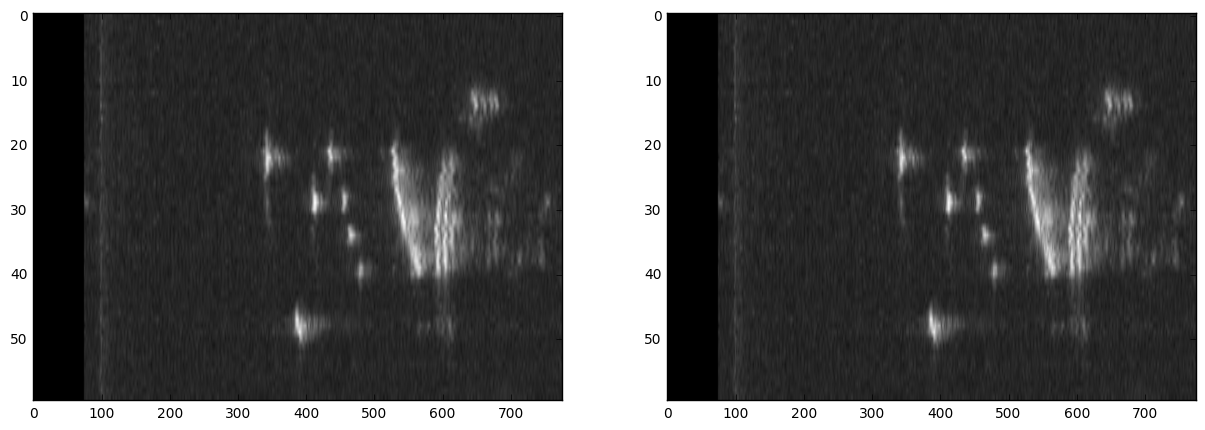

In [28]:
f, axarr = plt.subplots(1,2,figsize=(15,5))
axarr[0].imshow(RawImg,cmap=plt.get_cmap('gray'),aspect='auto',)
axarr[1].imshow(CleanedImage,cmap=plt.get_cmap('gray'),aspect='auto',)
plt.show()

In [12]:
def CreateSC(RawImgData):
    LenLinesC = np.shape(RawImgData)[1]

    SC = np.zeros((LenLinesC,LenLinesC))
    SC += 1
    maxAngle = 60.0
    step = maxAngle/(NbLinesC+1)
    CosAngle = math.cos(math.radians(30))
    Limit = LenLinesC*CosAngle

    points = []
    values = []

    for i in range(LenLinesC):
        for j in range(LenLinesC):
            if (  (j > LenLinesC/2 + i/(2*CosAngle)) or  (j < LenLinesC/2 - i/(2*CosAngle)) ):
                SC[i][j] = 0
                points.append([i,j])
                values.append(0)
            if (  (i > Limit) ):
                if ( (i**2 + (j-LenLinesC/2) ** 2) > LenLinesC**2):
                    SC[i][j] = 0 
                    points.append([i,j])
                    values.append(0)
    for i in range(NbLinesC):
        PointAngle = i*step-30
        COS = math.cos(math.radians(PointAngle))
        SIN = math.sin(math.radians(PointAngle))
        for j in range(LenLinesC):

            X = (int)( j*COS)
            Y = (int)(LenLinesC/2 - j*SIN)
            SC[X][Y] = RawImgData[i][j]
            points.append([X,Y])
            values.append(RawImgData[i][j])

    values = np.array(values,dtype=np.int)
    
    return SC,values,points,LenLinesC


In [13]:
SCH,valuesH,pointsH,LenLinesCH = CreateSC(RawImg)
SCC,valuesC,pointsC,LenLinesCC = CreateSC(CleanedImage)

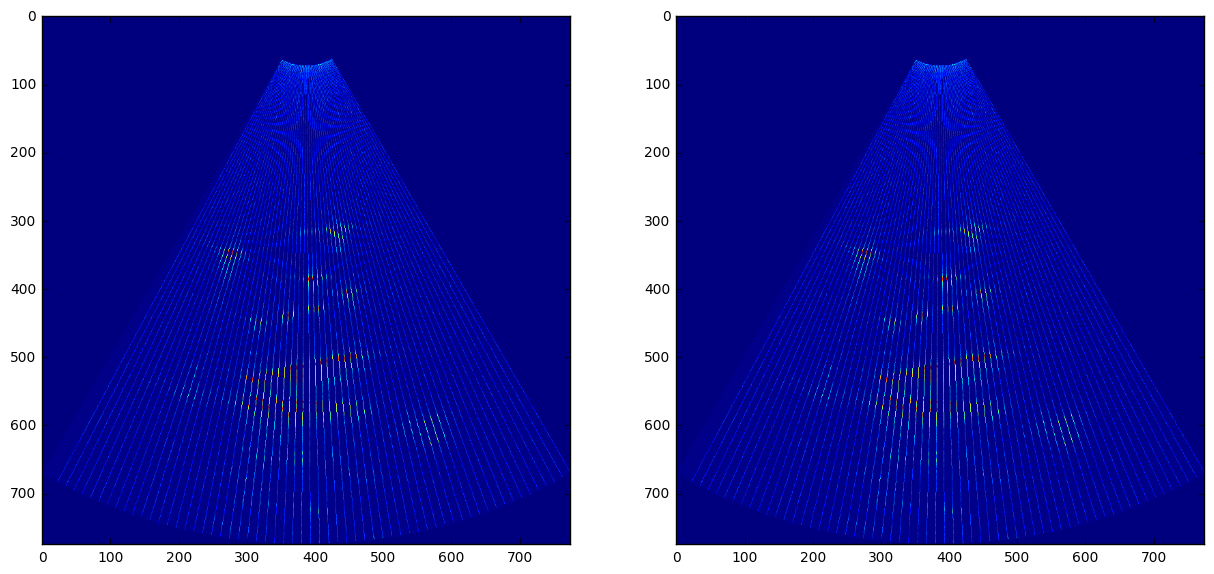

In [14]:
f, axarr = plt.subplots(1,2,figsize = (15,7))
axarr[0].imshow(SCH)
axarr[1].imshow(SCC)
plt.show()

In [15]:
grid_xH, grid_yH = np.mgrid[0:LenLinesCH:1, 0:LenLinesCH:1]
grid_xC, grid_yC = np.mgrid[0:LenLinesCC:1, 0:LenLinesCC:1]

In [38]:
#grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1H = griddata(pointsH, valuesH, (grid_xH, grid_yH), method='linear')
grid_z1C = griddata(pointsC, valuesC, (grid_xC, grid_yC), method='linear')

In [39]:
grid_z1 = griddata(pointsH, valuesH, (grid_xH, grid_yH), method='cubic')

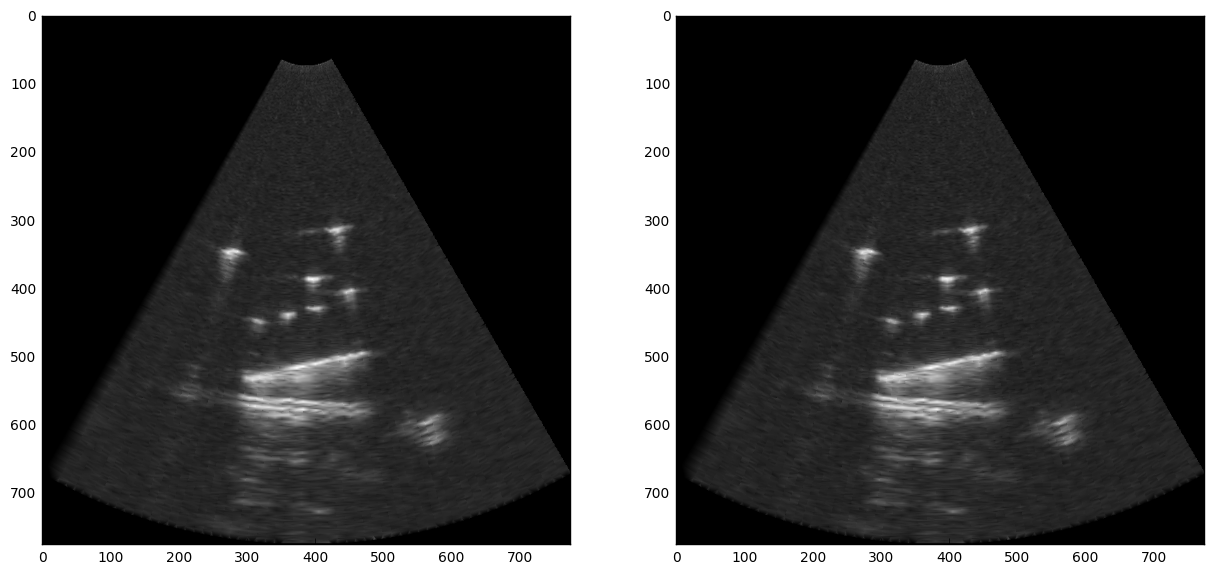

In [69]:
f, axarr = plt.subplots(1,2,figsize = (15,7))
axarr[0].imshow(grid_z1H,cmap=plt.get_cmap('gray'))
axarr[1].imshow(grid_z1C,cmap=plt.get_cmap('gray'))
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in power


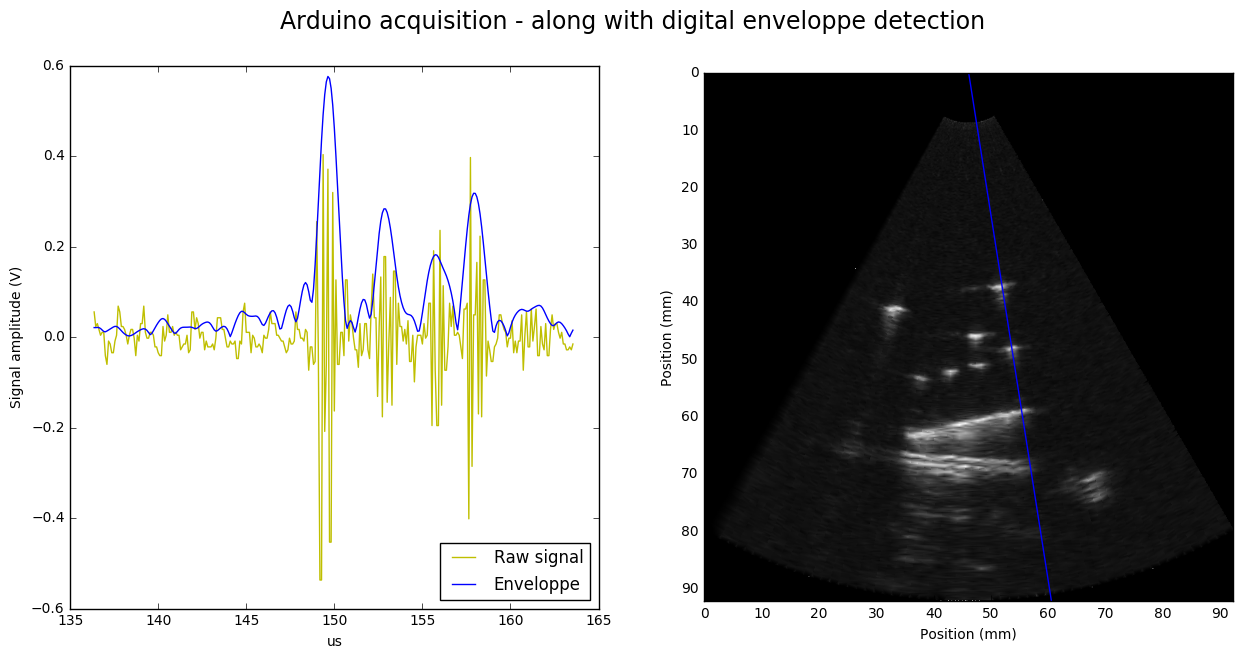

In [144]:
mmVal = []
mmLbl = []
step = 60/(NbLinesC+1)
f, axarr = plt.subplots(1,2,figsize = (15,7))
f.suptitle("Arduino acquisition - along with digital enveloppe detection",fontsize = "17")

axarr[0].set_xlabel("us")
axarr[0].set_ylabel("Signal amplitude (V)")
axarr[0].plot(t[1500:1800],Line[1500:1800]*3.3/512,"y", label='Raw signal')
axarr[0].plot(t[1500:1800],(SigHF)[1500:1800]/100,"b", label='Enveloppe')


axarr[1].plot( [np.shape(grid_z1)[1]*(0.5), np.shape(grid_z1C)[1]*(1-103.0/300)],[0,np.shape(grid_z1C)[1]],'b')



for k in range (np.shape(grid_z1)[1]):
    if not(k%int(112*0.75)):
        mmVal.append(k)
        mmLbl.append(int(k/(11.2*0.75)))
plt.xticks(mmVal,mmLbl)     
plt.yticks(mmVal,mmLbl)
axarr[1].set_xlabel("Position (mm)")
axarr[1].set_ylabel("Position (mm)")
axarr[0].legend(loc='lower right')
axarr[1].imshow((grid_z1C**1.4),cmap=plt.get_cmap('gray'))
plt.savefig('LineImageEnveloppe.jpg', bbox_inches='tight')
plt.show()

In [148]:
import re
tmp = '@kelu include(/lol/)'
tmp

'@kelu include(/lol/)'

In [152]:
pattern = r'@kelu include\((.*?)\)'
results = re.findall(pattern, tmp, flags=0) 
print results

['/lol/']
